# Dependencies

In [1]:
import numpy as np
import scipy as sp
import seaborn as sn
import pandas as pd
import matplotlib
# matplotlib.use('agg')
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation
import time
from IPython.display import HTML, Image, Video
from tqdm import tqdm
import os
import xarray as xr
import gc
import multiprocessing
import glob

from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

## Matplotlib rcparams setup:
plt.style.use('/home/leachl/Documents/Thesis/ancil/figure-style.mplstyle')
## textwidth of Thesis
textwidth = 5.848611111111111
## palette
palette = get_palette.color_blind().to_sn_palette()

%matplotlib inline

# Introduction
This notebook uses the Lorenz '63 system to demonstrate the conceptual differences between conventional "probabilistic" climate-model based attribution and our forecast-based approach. 

The specific system used is the Palmer '99 variant of the Lorenz dynamical model, which includes a forcing (at an angle $\theta$ in the xy place) to the system, representing some external forcing - eg. anthropogenic greenhouse gas emissions. The equations of this system are as follows:

$
\begin{align}
\dot{x} & = \sigma(y-x) + f_0 \cos\theta \\
\dot{y} & = x (\rho - z) - y + f_0 \sin\theta \\
\dot{z} & = xy - \beta z
\end{align}
$

Lorenz, E. N. (1963). Deterministic Nonperiodic Flow. Journal of the Atmospheric Sciences. [DOI](https://doi.org/10.1175/1520-0469(1963)020<0130:DNF>2.0.CO;2)

Palmer, T. N. (1999). A Nonlinear Dynamical Perspective on Climate Prediction. Journal of Climate, 12(2), 575–591. [DOI](https://doi.org/10.1175/1520-0442(1999)012<0575:ANDPOC>2.0.CO;2)

In [2]:
def lorenz(xyz, t, rho=28, sigma=10, beta=8/3, F=0, theta=0):
    
    "Defines the lorez63 dynamical system. Standard default values."
    
    x, y, z = xyz
    x_dot = sigma * (y - x) + F * np.cos(theta)
    y_dot = x * rho - x * z - y + F * np.sin(theta)
    z_dot = x * y - beta * z
    return [x_dot, y_dot, z_dot]

# set Lorenz system parameters
s = 10
r = 28
b = 8/3
F = (8,np.deg2rad(-40))

# Definitions

## Locate analogues
We'll do this with numpy because MUCH easier

In [3]:
def get_analogs(event,ds,n=100):
    
    ds = ds.copy()
    ds['ED'] = (((ds - event)**2).to_array().sum('variable')**(1/2))
    
    def preproc_ED(ds):
    
        ds = ds.copy()
        ds = ds.sortby('ED')
        ds['time0'] = ds.time

        return ds.rename(time='rank').assign_coords(rank=np.arange(ds.time.size))

    ds = xr.concat([preproc_ED(ds.sel(type=x)) for x in ds.type.values],dim='type')
    
    return ds.isel(rank=range(n))

# Explore "full" attractor

In [4]:
full = xr.open_mfdataset('Lorenz63-realisations/005*.nc',preprocess=lambda x:x.squeeze())
full = full.load()

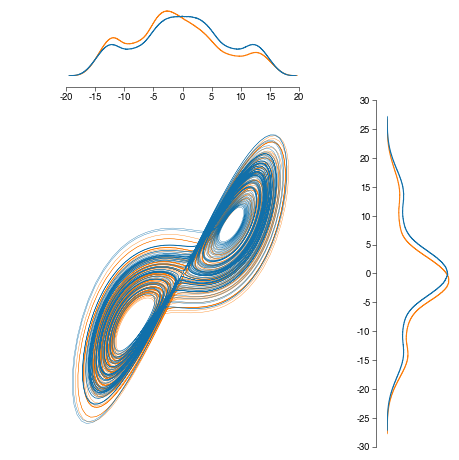

In [5]:
fig = plt.figure()
gs = matplotlib.gridspec.GridSpec(5,5,figure=fig)

ax = fig.add_subplot(gs[1:,:-1])
ax_x = fig.add_subplot(gs[0,:-1])
ax_y = fig.add_subplot(gs[1:,-1])

## plot main butterfly
ax.plot(*full.isel(time=range(10000)).sel(type='forced').to_array().variable.values[:2],color=palette[1],lw=0.33)
ax.plot(*full.isel(time=range(10000)).sel(type='unforced').to_array().variable.values[:2],color=palette[0],lw=0.33)

## plot distributions
ax_x.hist(full.sel(type='forced').x.values,histtype='step',color=palette[1],lw=1)
ax_x.hist(full.sel(type='unforced').x.values,histtype='step',color=palette[0],lw=1)
ax_y.hist(full.sel(type='forced').y.values,orientation='horizontal',histtype='step',color=palette[1],lw=1)
ax_y.hist(full.sel(type='unforced').y.values,orientation='horizontal',histtype='step',color=palette[0],lw=1)

# axes layout options
ax.axis('off')
ax_x.set_yticks([])
ax_x.set_xticks(np.arange(-20,21,5))
ax_y.set_xticks([])
ax_y.set_yticks(np.arange(-30,31,5))

sn.despine(ax=ax_x,left=True,offset=10,trim=True)
sn.despine(ax=ax_y,bottom=True,offset=10,trim=True)

[a.set_xlim(-30,30) for a in [ax,ax_x]]
[a.set_ylim(-30,30) for a in [ax,ax_y]]

## output figure options
fig.patch.set_facecolor('xkcd:white')
aspect = 1
fig.set_size_inches(textwidth,textwidth*aspect)
plt.tight_layout(w_pad=0,h_pad=0)
fig.dpi=80

### Select specific extreme event

In [6]:
event_time = 7680104

event = full.sel(type='forced').isel(time=7680104)

ic_times = xr.DataArray(data=[0,-10,-20,-30,-40,-50,-60,-70,-80,-90,-100,-200,-500,-1000],dims=['lead'],coords={'lead':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,5,10]})

ics = full.sel(type='forced').isel(time=event_time+ic_times)

In [7]:
ics.to_netcdf('Lorenz63-realisations/analogs/ics.nc')

## Get distance to ics

In [8]:
ics = xr.open_dataset('Lorenz63-realisations/analogs/ics.nc')

In [9]:
def get_analogs(x,x0,n=1000,D=2):
    
    # try analogs based on 2D distance to y & z (our snythetic "dynamical" variables)
    D0 = ((((x - x0)**2)[['y','z']].to_array().sum('variable'))**(1/2)).values
    
    idx = np.arange(x.time.size)[D0 < D]
    
    ana = x.isel(time=np.random.choice(idx,n))
    
    ana_time = ana.time.values
    
    ana = ana.assign_coords(time=np.arange(n)).rename(time='analog')
    
    ana['time'] = ('analog',ana_time)
    
    return ana

In [10]:
analogs = []

for fpath in tqdm(sorted(glob.glob('Lorenz63-realisations/*.nc'))[1:]):
    
    branch = xr.open_dataset(fpath)
    
    analogs += [xr.concat([branch.groupby('type').apply(lambda x: get_analogs(x.squeeze(),ics.isel(lead=l))).expand_dims({'lead':[ics.lead.isel(lead=l)]}) for l in np.arange(ics.lead.size)],dim='lead')]
    
analogs = xr.concat(analogs,dim='branch').stack(a = ['analog','branch'])

100%|██████████| 100/100 [20:33<00:00, 12.34s/it]


# Initialised attribution

## Load analogs and initialise model

In [39]:
members = 1000
fcs=[]
for lead in tqdm(analogs.lead.values):
    
    IC_set0 = analogs.sel(type='unforced',lead=lead)
#     IC_set0 = IC_set0.sel(rank=IC_set.ED<2)
    ICs0 = IC_set0.isel(a = np.random.choice(IC_set0.a.size,members))[['x','y','z']].to_array().values.T
    
    IC_set1 = analogs.sel(type='forced',lead=lead)
#     IC_set1 = IC_set1.sel(rank=IC_set.ED<2)
    ICs1 = IC_set1.isel(a = np.random.choice(IC_set1.a.size,members))[['x','y','z']].to_array().values.T
    
    fclength = lead+0.4
    timestep = 0.01
    index = np.arange(0,fclength+timestep,timestep)
    
    fcs0 = np.array([sp.integrate.odeint(lorenz, ic, index, (r,s,b,0,0)) for ic in ICs0])
    fcs0 = xr.DataArray(data=fcs0[None,None,],dims=['type','lead','number','time','variable'],coords=dict(type=['unforced-ic0'],lead=[lead],number=np.arange(members),time=index-lead,variable=['x','y','z'])).to_dataset(dim="variable")
    
    fcs01 = np.array([sp.integrate.odeint(lorenz, ic, index, (r,s,b,0,0)) for ic in ICs1])
    fcs01 = xr.DataArray(data=fcs01[None,None,],dims=['type','lead','number','time','variable'],coords=dict(type=['unforced-ic1'],lead=[lead],number=np.arange(members),time=index-lead,variable=['x','y','z'])).to_dataset(dim="variable")
    
    fcs1 = np.array([sp.integrate.odeint(lorenz, ic, index, (r,s,b,*F)) for ic in ICs1])
    fcs1 = xr.DataArray(data=fcs1[None,None,],dims=['type','lead','number','time','variable'],coords=dict(type=['forced-ic1'],lead=[lead],number=np.arange(members),time=index-lead,variable=['x','y','z'])).to_dataset(dim="variable")
    
    fcs += [xr.concat([fcs0,fcs1,fcs01],dim='type')]
    
fcs = xr.concat(fcs,dim='lead')

100%|██████████| 14/14 [02:45<00:00, 11.79s/it]


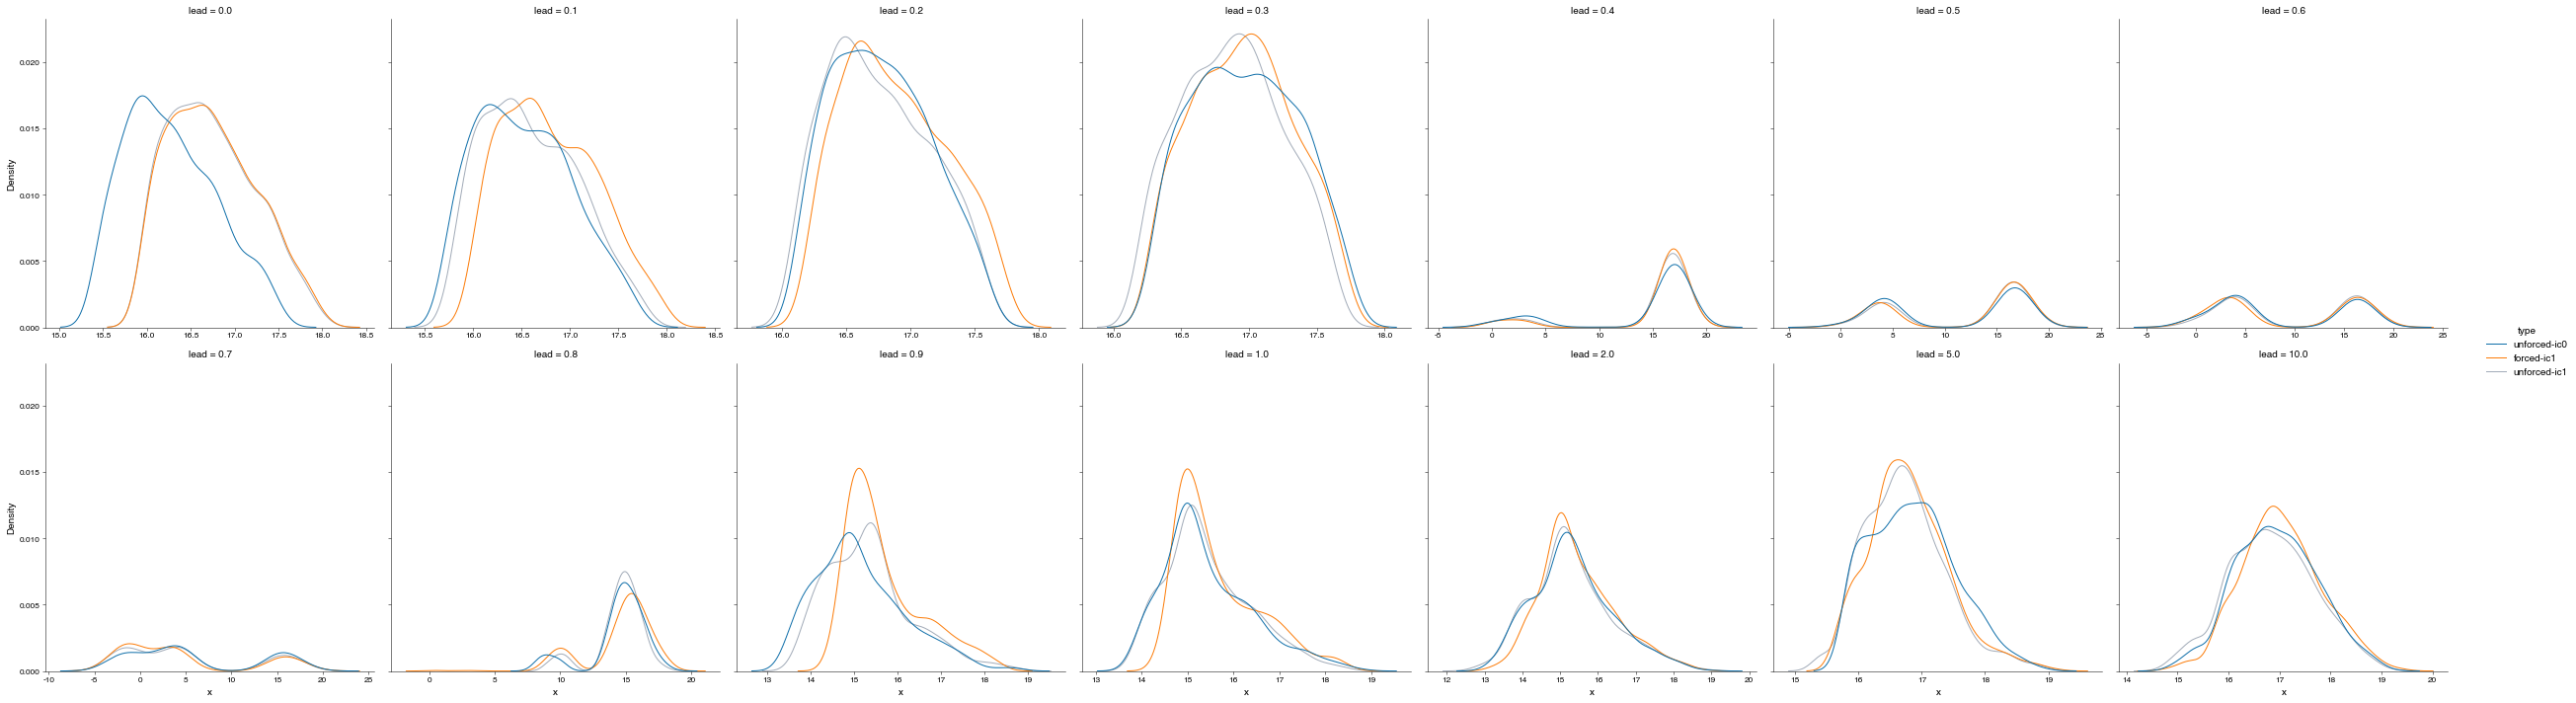

In [40]:
sn.displot(data=fcs.x.max('time').to_dataframe().reset_index(),x='x',hue='type',col='lead',col_wrap=7,kind='kde',facet_kws=dict(sharex=False))

In [41]:
## some statistics
fcs_theshold_prob = 1-(fcs.max('time').x.to_dataframe().groupby(['type','lead']).apply(lambda x: sp.stats.percentileofscore(x,17))/100).unstack()
fcs_threshold_rr = fcs_theshold_prob / fcs_theshold_prob.loc['forced-ic1']

In [42]:
fcs_threshold_rr

lead,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0,5.0,10.0
type,,,,,,,,,,,,,,
forced-ic1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
unforced-ic0,0.324675,0.532764,0.771053,1.032258,1.028351,0.930233,0.784,0.888889,0.552381,0.535088,0.733945,0.804348,1.218659,0.941532
unforced-ic1,0.974026,0.672365,0.755263,0.834409,0.894330,0.869767,0.848,0.925926,0.333333,0.649123,0.688073,0.880435,0.880466,0.852823


In [43]:
analog_rank = ((((ics.sel(lead=0)-analogs.sel(lead=0))**2).y+((ics.sel(lead=0)-analogs.sel(lead=0))**2).z)**(1/2)).to_pandas().T.apply(lambda x: x.sort_values().index.values)

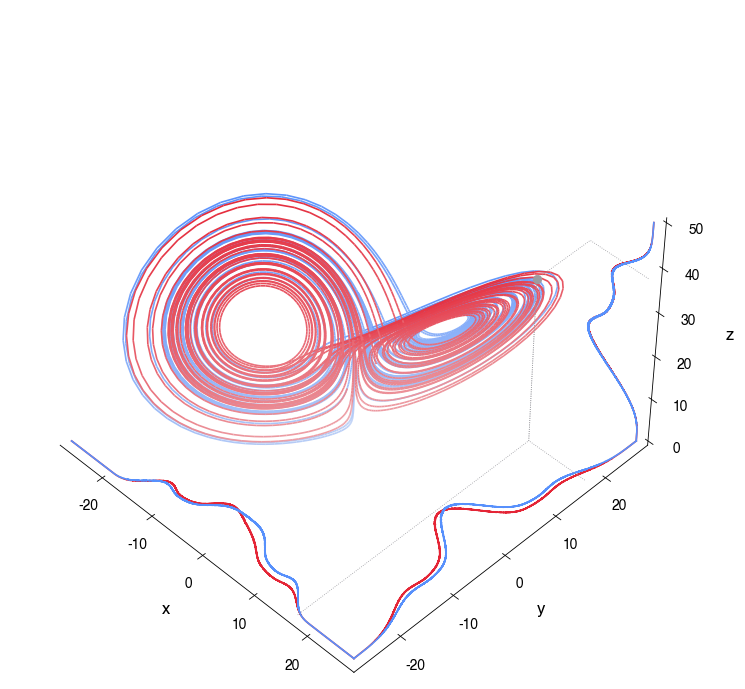

In [44]:
cmaps = dict(forced=sn.light_palette(get_palette.Petroff6().to_sn_palette()[2],as_cmap=True),unforced=sn.light_palette(get_palette.Petroff6().to_sn_palette()[0],as_cmap=True))
norm = matplotlib.colors.Normalize(-25,full.z.max())

xmin,xmax=-27.5,27.5
ymin,ymax=-27.5,27.5
zmin,zmax=0,50

fig=plt.figure()
ax=plt.axes(projection='3d')

## draw the main attractor
for runtype in ['forced','unforced']:
    x,y,z = full.isel(time=slice(1,5000)).sel(type=runtype).to_array().variable.values
    points = np.array([x,y,z]).T.reshape(-1,1,3)
    segments = np.concatenate([points[:-1],points[1:]],axis=1)

    lc = mplot3d.art3d.Line3DCollection(segments,cmap=cmaps[runtype],norm=norm)
    ### Set the values used for colormapping
    lc.set_array(z)
    ax.add_collection3d(lc)

## draw the marginal histograms
xybins = np.arange(xmin,xmax+1e-5,0.01)
zbins = np.arange(zmin,zmax+1e-5,0.01)
for runtype in ['forced','unforced']:
    x,y,z = full.sel(type=runtype).to_array().variable.values
    histx,binsx = np.histogram(x,bins=xybins)
    histy,binsy = np.histogram(y,bins=xybins)
    histz,binsz = np.histogram(z,bins=zbins)
    ax.plot(binsx,ymin+np.insert(histx,0,0)/histx.max()*7.5,zs=zmin,zdir='z',color=cmaps[runtype](cmaps[runtype]._i_over))
    ax.plot(xmax-np.insert(histy,0,0)/histy.max()*10,binsy,zs=zmin,zdir='z',color=cmaps[runtype](cmaps[runtype]._i_over))
    ax.plot(xmax-np.insert(histz,0,0)/histz.max()*10,binsz,zs=ymax,zdir='y',color=cmaps[runtype](cmaps[runtype]._i_over))
    
## draw the event
icx,icy,icz = ics.sel(lead=0).to_array().values
ax.plot(icx,icy,icz,'o',ms=5,color=get_palette.Petroff6().to_sn_palette()[-2],zorder=10)
ax.plot([icx,icx,xmax],[icy,ymax,ymax],[icz,icz,icz],color=get_palette.Petroff6().to_sn_palette()[-2],ls=':',zorder=10,lw=0.5)
ax.plot([icx,icx,xmax],[icy,icy,icy],[icz,zmin,zmin],color=get_palette.Petroff6().to_sn_palette()[-2],ls=':',zorder=10,lw=0.5)
ax.plot([icx,icx,icx],[icy,icy,ymin],[icz,zmin,zmin],color=get_palette.Petroff6().to_sn_palette()[-2],ls=':',zorder=10,lw=0.5)

    
## output axes layout
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(45,315)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(False)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.set_zlim(zmin,zmax)

## output figure options
fig.patch.set_facecolor('xkcd:white')
aspect = 1
fig.set_size_inches(textwidth,textwidth*aspect)
plt.tight_layout(w_pad=0,h_pad=0)
fig.dpi=120

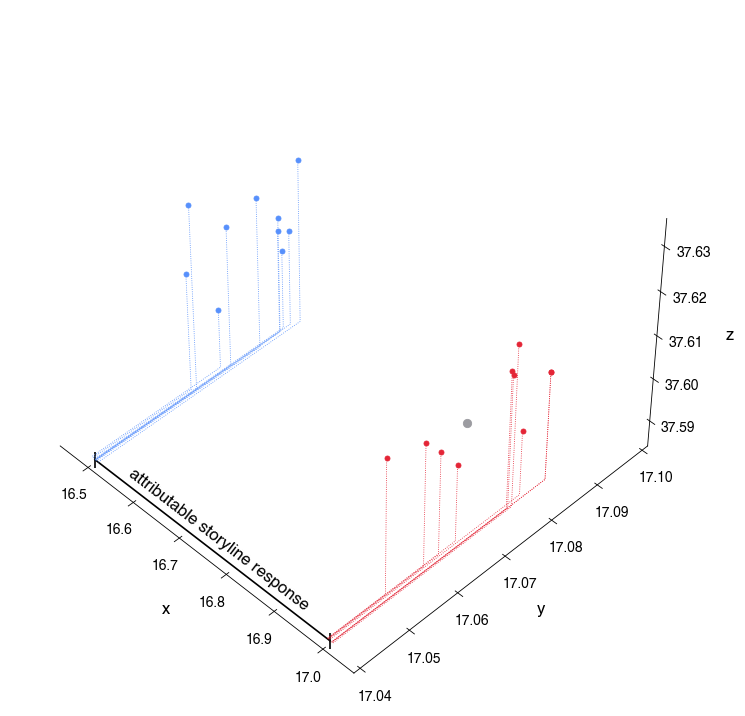

In [45]:
## analogs plot
xmin,xmax=16.45,17.05
ymin,ymax=17.04,17.1
zmin,zmax=37.585,37.635

fig=plt.figure()
ax=plt.axes(projection='3d')

for a_rank in analog_rank.iloc[:10].forced.values:
    xf,yf,zf = analogs.sel(lead=0,type='forced',a=a_rank).get(['x','y','z']).to_array().variable.values
    ax.plot(xf,yf,zf,'o',color=get_palette.Petroff6().to_sn_palette()[2])
    ax.plot([xf,xf,xf],[yf,yf,ymin],[zf,zmin,zmin],color=get_palette.Petroff6().to_sn_palette()[2],ls=':',zorder=10,lw=0.5)
    
for a_rank in analog_rank.iloc[:10].unforced.values:
    xf,yf,zf = analogs.sel(lead=0,type='unforced',a=a_rank).get(['x','y','z']).to_array().variable.values
    ax.plot(xf,yf,zf,'o',color=get_palette.Petroff6().to_sn_palette()[0])
    ax.plot([xf,xf,xf],[yf,yf,ymin],[zf,zmin,zmin],color=get_palette.Petroff6().to_sn_palette()[0],ls=':',zorder=10,lw=0.5)

icx,icy,icz = ics.sel(lead=0).to_array().values
ax.plot(icx,icy,icz,'o',ms=5,color=get_palette.Petroff6().to_sn_palette()[-2],zorder=10)

ax.plot([analogs.sel(lead=0,type='forced',a=analog_rank.iloc[:10].forced.values).x.mean(),analogs.sel(lead=0,type='unforced',a=analog_rank.iloc[:10].unforced.values).x.mean()],[ymin,ymin],[zmin,zmin],'|k',ls='-',ms=10,mew=1)

ax.text(16.75,ymin+0.002,zmin,'attributable storyline response',zdir='x',va='center',ha='center')

## output axes layout
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(45,315)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(False)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.set_zlim(zmin,zmax)

## output figure options
fig.patch.set_facecolor('xkcd:white')
aspect = 1
fig.set_size_inches(textwidth,textwidth*aspect)
plt.tight_layout(w_pad=0,h_pad=0)
fig.dpi=120

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


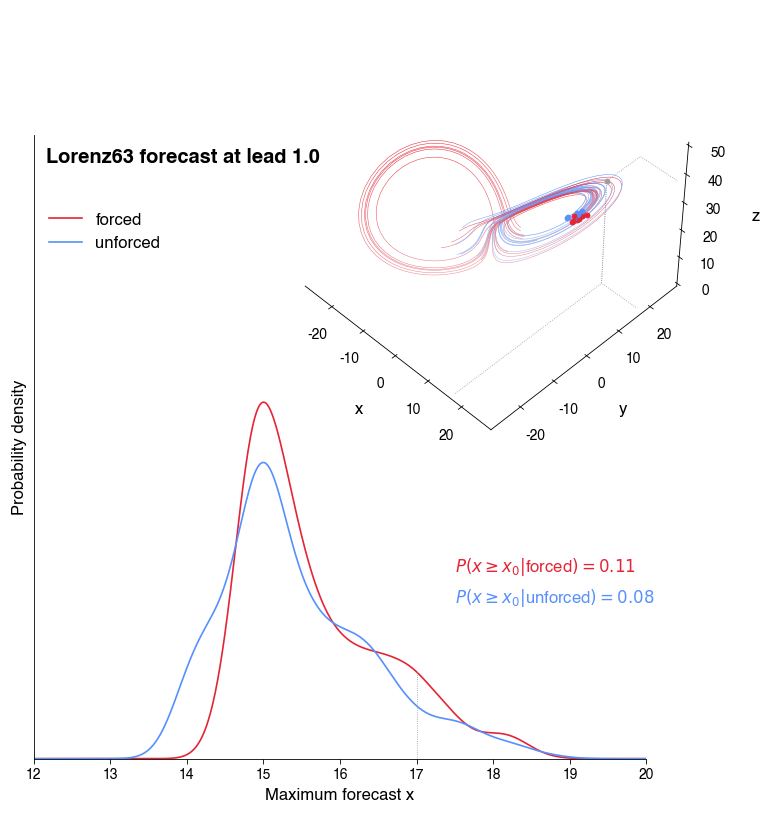

In [53]:
lead=1

fcsdata = fcs.sel(lead=lead,time=slice(0) if lead==0.0 else slice(None))

cmaps = dict(forced=sn.light_palette(get_palette.Petroff6().to_sn_palette()[2],as_cmap=True),unforced=sn.light_palette(get_palette.Petroff6().to_sn_palette()[0],as_cmap=True))
norm = matplotlib.colors.Normalize(-25,full.z.max())

xmin,xmax=-27.5,27.5
ymin,ymax=-27.5,27.5
zmin,zmax=0,50

fig=plt.figure()
ax0=plt.axes()
ax=plt.axes([0.4,0.55,0.6,0.6],projection='3d')

def plot_member(member,**kwargs):
    
    x,y,z = member.dropna('time').to_array().values
    ax.plot(x[0],y[0],z[0],'o',ms=3,**kwargs)
    
    points = np.array([x,y,z]).T.reshape(-1,1,3)
    segments = np.concatenate([points[:-1],points[1:]],axis=1)

    lc = mplot3d.art3d.Line3DCollection(segments,cmap=cmaps[member.type.values[()].split('-')[0]],norm=norm,lw=kwargs['lw'])
    ### Set the values used for colormapping
    lc.set_array(z)
    ax.add_collection3d(lc)
    
for number in np.random.choice(1000,10):
    
    member = fcsdata.sel(type='unforced-ic0',number=number).dropna('time')
    plot_member(member,color=get_palette.Petroff6().to_sn_palette()[0],lw=0.33,zorder=30)
    
    member = fcsdata.sel(type='forced-ic1',number=number).dropna('time')
    plot_member(member,color=get_palette.Petroff6().to_sn_palette()[2],lw=0.33,zorder=30)
    
## draw the event
icx,icy,icz = ics.sel(lead=0).to_array().values
ax.plot(icx,icy,icz,'o',ms=3,color=get_palette.Petroff6().to_sn_palette()[-2],zorder=100)
ax.plot([icx,icx,xmax],[icy,ymax,ymax],[icz,icz,icz],color=get_palette.Petroff6().to_sn_palette()[-2],ls=':',zorder=10,lw=0.5)
ax.plot([icx,icx,xmax],[icy,icy,icy],[icz,zmin,zmin],color=get_palette.Petroff6().to_sn_palette()[-2],ls=':',zorder=10,lw=0.5)
ax.plot([icx,icx,icx],[icy,icy,ymin],[icz,zmin,zmin],color=get_palette.Petroff6().to_sn_palette()[-2],ls=':',zorder=10,lw=0.5)
    
## plot histograms
xbins = np.arange(12,20+1e-5,0.01)
kde17 = []
kdemax = []
for i,runtype in enumerate(['forced-ic1','unforced-ic0']):
    x = fcsdata.sel(type=runtype).x.max('time').values
    runtype=runtype.split('-')[0]
    kde = sp.stats.gaussian_kde(x)
    ax0.plot(xbins,kde(xbins),color=cmaps[runtype](cmaps[runtype]._i_over),label=runtype)
    kde17+=[kde(17)]
    kdemax+=[kde(xbins).max()]

## hist axes
sn.despine(ax=ax0)
ax0.set_yticks([])
ax0.set_xlim(12,20)
ylims = ax0.set_ylim(0,max(kdemax)*1.75)
ax0.set_xlabel('Maximum forecast x')
ax0.set_ylabel('Probability density')
ax0.vlines(17,0,max(kde17),ls=':',color=get_palette.Petroff6().to_sn_palette()[-2],zorder=10,lw=0.5)
ax0.legend(loc='upper left',bbox_to_anchor=(0,0.9))

for j,(i,x) in enumerate(fcs.sel(lead=lead,type=['forced-ic1','unforced-ic0']).x.max('time').to_pandas().T.apply(lambda x: sp.stats.percentileofscore(x,17)).iteritems()):
    runtype=i.split('-')[0]
    xloc = ax0.transAxes.inverted().transform(ax0.transData.transform((17.5,0)))[0]
    ax0.text(xloc,0.3-j/20,'$P(x\geq x_0|$'+runtype+'$)={0:.2f}$'.format(1-x/100),transform=ax0.transAxes,color=cmaps[runtype](cmaps[runtype]._i_over))
    
ax0.text(0.02,0.98,'Lorenz63 forecast at lead {0:.1f}'.format(lead),transform=ax0.transAxes,va='top',ha='left',fontweight='bold',fontsize='large')

## output axes layout
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(45,315)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.grid(False)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.set_zlim(zmin,zmax)
ax.patch.set_facecolor((0,0,0,0.0))

## output figure options
fig.patch.set_facecolor('xkcd:white')
aspect = 1
fig.set_size_inches(textwidth,textwidth*aspect)
plt.tight_layout(w_pad=0,h_pad=0)
fig.dpi=120